In [1]:
import pandas as pd
import re
import nltk
import random
import numpy as np
import tensorflow as tf
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.layers import TextVectorization, Embedding, LSTM, Dense, Concatenate, Dropout, Lambda, Input
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.backend import l2_normalize, sum
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve, auc)
import seaborn as sns
import xgboost as xgb

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
2024-11-23 15:31:09.181335: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732372269.199414  309438 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732372269.204952  309438 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-23 15:31:09.224583: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable

In [2]:
SEED = 1
MODEL_IMG_FILENAME = 'output/lstm.png'
SERIALIZED_MODEL_FILENAME = 'output/lstm.weights.h5'
SERIALIZED_VECTORIZER_FILENAME = 'output/vectorizer.keras'

In [3]:
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
tf.keras.utils.set_random_seed(SEED)

nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /home/wojtek/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/wojtek/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [4]:
resumes_job_postings = pd.read_csv('../../data/resumes_job_postings.csv')
resumes_job_postings.head()

,resume_text,job_description_text,label
0,SummaryHighly motivated Sales Associate with e...,Net2Source Inc. is an award-winning total work...,No Fit
1,Professional SummaryCurrently working with Cat...,At Salas OBrien we tell our clients that were ...,No Fit
2,SummaryI started my construction career in Jun...,Schweitzer Engineering Laboratories (SEL) Infr...,No Fit
3,SummaryCertified Electrical Foremanwith thirte...,"Mizick Miller & Company, Inc. is looking for a...",No Fit
4,SummaryWith extensive experience in business/r...,Life at Capgemini\nCapgemini supports all aspe...,No Fit


# Pre-processing

In [5]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = text.lower()
    text = ' '.join([lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words])
    return text

resumes_job_postings['resume_text'] = resumes_job_postings['resume_text'].apply(clean_text)
resumes_job_postings['job_description_text'] = resumes_job_postings['job_description_text'].apply(clean_text)

label_encoder = LabelEncoder()
resumes_job_postings['label'] = label_encoder.fit_transform(resumes_job_postings['label'])

X_train, X_test, y_train, y_test = train_test_split(
    resumes_job_postings[['resume_text', 'job_description_text']], resumes_job_postings['label'], test_size=0.2, random_state=SEED
)

max_len = 100
vectorizer = TextVectorization(max_tokens=10000, output_mode='int', output_sequence_length=max_len)

vectorizer.adapt(pd.concat([X_train['resume_text'], X_train['job_description_text']]))

X_train_resume = vectorizer(X_train['resume_text'])
X_train_job_desc = vectorizer(X_train['job_description_text'])
X_test_resume = vectorizer(X_test['resume_text'])
X_test_job_desc = vectorizer(X_test['job_description_text'])

X_train_combined = np.hstack([X_train_resume, X_train_job_desc])
X_test_combined = np.hstack([X_test_resume, X_test_job_desc])

W0000 00:00:1732372291.109275  309438 gpu_device.cc:2344] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


# Random forrest

In [6]:
rf_model = RandomForestClassifier(random_state=SEED)
rf_model.fit(X_train_combined, y_train)
rf_y_pred = rf_model.predict(X_test_combined)
rf_accuracy = accuracy_score(y_test, rf_y_pred)

print(f"Random Forest Accuracy: {rf_accuracy:.4f}")

Random Forest Accuracy: 0.6656


# Logistic regression

In [7]:
lr_model = LogisticRegression(random_state=SEED)
lr_model.fit(X_train_combined, y_train)
lr_y_pred = lr_model.predict(X_test_combined)
lr_accuracy = accuracy_score(y_test, lr_y_pred)

print(f"Logistic Regression Accuracy: {lr_accuracy:.4f}")

Logistic Regression Accuracy: 0.5238


/home/wojtek/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


# SVM

In [8]:
svm_model = SVC(random_state=SEED)
svm_model.fit(X_train_combined, y_train)
svm_y_pred = svm_model.predict(X_test_combined)
svm_accuracy = accuracy_score(y_test, svm_y_pred)

print(f"SVM Accuracy: {svm_accuracy:.4f}")

SVM Accuracy: 0.5975


# Neural Networks (MLP)

In [9]:
mlp_model = MLPClassifier(random_state=SEED)
mlp_model.fit(X_train_combined, y_train)
mlp_y_pred = mlp_model.predict(X_test_combined)
mlp_accuracy = accuracy_score(y_test, mlp_y_pred)

print(f"MLP Accuracy: {mlp_accuracy:.4f}")

MLP Accuracy: 0.5269


# XGBoost

In [10]:
xgb_model = xgb.XGBClassifier(random_state=SEED)
xgb_model.fit(X_train_combined, y_train)
xgb_y_pred = xgb_model.predict(X_test_combined)
xgb_accuracy = accuracy_score(y_test, xgb_y_pred)

print(f"XGBoost Accuracy: {xgb_accuracy:.4f}")

XGBoost Accuracy: 0.6913


# LSTM based Neural Network

In [11]:
param_grid = {
    'learning_rate': [0.001, 0.01, 0.1],
    'batch_size': [8, 16],
    'dropout_rate': [0.3, 0.4],
    'lstm_units': [64, 128],
    'epochs': [10, 15],
    'embedding_dim': [64, 128]
}

best_model = None
best_params = None
best_test_accuracy = 0
best_history = None

results = []

combinations = ParameterGrid(param_grid)

total_combinations = len(combinations)
completed_combinations = 0

print(f"Starting grid search over {total_combinations} combinations...")

for params in combinations:
    learning_rate = params.pop('learning_rate')
    batch_size = params.pop('batch_size')
    dropout_rate = params.pop('dropout_rate')
    lstm_units = params.pop('lstm_units')
    epochs = params.pop('epochs')
    embedding_dim = params.pop('embedding_dim')

    input_resume = Input(shape=(max_len,))
    input_job_desc = Input(shape=(max_len,))

    embedding = Embedding(input_dim=10000, output_dim=embedding_dim)

    encoded_resume = embedding(input_resume)
    encoded_job_desc = embedding(input_job_desc)

    shared_lstm = LSTM(lstm_units, return_sequences=True)

    lstm_resume = shared_lstm(encoded_resume)
    lstm_job_desc = shared_lstm(encoded_job_desc)

    resume_pooling = Lambda(lambda x: sum(x, axis=1), output_shape=(lstm_units,))(lstm_resume)
    job_desc_pooling = Lambda(lambda x: sum(x, axis=1), output_shape=(lstm_units,))(lstm_job_desc)

    normalized_resume = Lambda(lambda x: l2_normalize(x, axis=1), output_shape=(lstm_units,))(resume_pooling)
    normalized_job_desc = Lambda(lambda x: l2_normalize(x, axis=1), output_shape=(lstm_units,))(job_desc_pooling)

    cosine_similarity = Lambda(lambda x: sum(x[0] * x[1], axis=1, keepdims=True), output_shape=(1,))([normalized_resume, normalized_job_desc])

    merged = Concatenate()([normalized_resume, normalized_job_desc, cosine_similarity])
    dense = Dense(64, activation='relu', kernel_regularizer=l2(0.001))(merged)
    dropout = Dropout(dropout_rate)(dense)
    output = Dense(3, activation='softmax', kernel_regularizer=l2(0.001))(dropout)

    model = Model(inputs=[input_resume, input_job_desc], outputs=output)
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    history = model.fit([X_train_resume, X_train_job_desc], y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2, verbose=0)

    test_loss, test_accuracy = model.evaluate([X_test_resume, X_test_job_desc], y_test, verbose=0)

    results.append({
        'learning_rate': learning_rate,
        'batch_size': batch_size,
        'dropout_rate': dropout_rate,
        'lstm_units': lstm_units,
        'epochs': epochs,
        'embedding_dim': embedding_dim,
        'train_loss': history.history['loss'][-1],
        'test_loss': history.history['val_loss'][-1],
        'train_accuracy': history.history['accuracy'][-1],
        'test_accuracy': history.history['val_accuracy'][-1]
    })

    if test_accuracy > best_test_accuracy:
        best_model = model
        best_params = params
        best_test_accuracy = test_accuracy
        best_history = history

    completed_combinations += 1
    print(f"Completed {completed_combinations}/{total_combinations} combinations...")
    print(f"Current Test Accuracy: {test_accuracy:.4f}")
    print(f"Current Best Test Accuracy: {best_test_accuracy:.4f}")

Starting grid search over 96 combinations...


/home/wojtek/.local/lib/python3.10/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor', 'keras_tensor_1']. Received: the structure of inputs=('*', '*')
  warnings.warn(


Completed 1/96 combinations...
Current Test Accuracy: 0.8181
Current Best Test Accuracy: 0.8181


/home/wojtek/.local/lib/python3.10/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_15', 'keras_tensor_16']. Received: the structure of inputs=('*', '*')
  warnings.warn(


Completed 2/96 combinations...
Current Test Accuracy: 0.8100
Current Best Test Accuracy: 0.8181


/home/wojtek/.local/lib/python3.10/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_30', 'keras_tensor_31']. Received: the structure of inputs=('*', '*')
  warnings.warn(


Completed 3/96 combinations...
Current Test Accuracy: 0.5031
Current Best Test Accuracy: 0.8181


/home/wojtek/.local/lib/python3.10/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_45', 'keras_tensor_46']. Received: the structure of inputs=('*', '*')
  warnings.warn(


Completed 4/96 combinations...
Current Test Accuracy: 0.5031
Current Best Test Accuracy: 0.8181


/home/wojtek/.local/lib/python3.10/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_60', 'keras_tensor_61']. Received: the structure of inputs=('*', '*')
  warnings.warn(


Completed 5/96 combinations...
Current Test Accuracy: 0.5031
Current Best Test Accuracy: 0.8181


/home/wojtek/.local/lib/python3.10/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_75', 'keras_tensor_76']. Received: the structure of inputs=('*', '*')
  warnings.warn(


Completed 6/96 combinations...
Current Test Accuracy: 0.5031
Current Best Test Accuracy: 0.8181


/home/wojtek/.local/lib/python3.10/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_90', 'keras_tensor_91']. Received: the structure of inputs=('*', '*')
  warnings.warn(


Completed 7/96 combinations...
Current Test Accuracy: 0.8213
Current Best Test Accuracy: 0.8213


/home/wojtek/.local/lib/python3.10/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_105', 'keras_tensor_106']. Received: the structure of inputs=('*', '*')
  warnings.warn(


Completed 8/96 combinations...
Current Test Accuracy: 0.7494
Current Best Test Accuracy: 0.8213


/home/wojtek/.local/lib/python3.10/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_120', 'keras_tensor_121']. Received: the structure of inputs=('*', '*')
  warnings.warn(


Completed 9/96 combinations...
Current Test Accuracy: 0.6456
Current Best Test Accuracy: 0.8213


/home/wojtek/.local/lib/python3.10/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_135', 'keras_tensor_136']. Received: the structure of inputs=('*', '*')
  warnings.warn(


Completed 10/96 combinations...
Current Test Accuracy: 0.5031
Current Best Test Accuracy: 0.8213


/home/wojtek/.local/lib/python3.10/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_150', 'keras_tensor_151']. Received: the structure of inputs=('*', '*')
  warnings.warn(


Completed 11/96 combinations...
Current Test Accuracy: 0.5031
Current Best Test Accuracy: 0.8213


/home/wojtek/.local/lib/python3.10/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_165', 'keras_tensor_166']. Received: the structure of inputs=('*', '*')
  warnings.warn(


Completed 12/96 combinations...
Current Test Accuracy: 0.5031
Current Best Test Accuracy: 0.8213


/home/wojtek/.local/lib/python3.10/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_180', 'keras_tensor_181']. Received: the structure of inputs=('*', '*')
  warnings.warn(


Completed 13/96 combinations...
Current Test Accuracy: 0.8275
Current Best Test Accuracy: 0.8275


/home/wojtek/.local/lib/python3.10/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_195', 'keras_tensor_196']. Received: the structure of inputs=('*', '*')
  warnings.warn(


Completed 14/96 combinations...
Current Test Accuracy: 0.5450
Current Best Test Accuracy: 0.8275


/home/wojtek/.local/lib/python3.10/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_210', 'keras_tensor_211']. Received: the structure of inputs=('*', '*')
  warnings.warn(


Completed 15/96 combinations...
Current Test Accuracy: 0.6338
Current Best Test Accuracy: 0.8275


/home/wojtek/.local/lib/python3.10/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_225', 'keras_tensor_226']. Received: the structure of inputs=('*', '*')
  warnings.warn(


Completed 16/96 combinations...
Current Test Accuracy: 0.5031
Current Best Test Accuracy: 0.8275


/home/wojtek/.local/lib/python3.10/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_240', 'keras_tensor_241']. Received: the structure of inputs=('*', '*')
  warnings.warn(


Completed 17/96 combinations...
Current Test Accuracy: 0.5031
Current Best Test Accuracy: 0.8275


/home/wojtek/.local/lib/python3.10/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_255', 'keras_tensor_256']. Received: the structure of inputs=('*', '*')
  warnings.warn(


Completed 18/96 combinations...
Current Test Accuracy: 0.5031
Current Best Test Accuracy: 0.8275


/home/wojtek/.local/lib/python3.10/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_270', 'keras_tensor_271']. Received: the structure of inputs=('*', '*')
  warnings.warn(


Completed 19/96 combinations...
Current Test Accuracy: 0.7912
Current Best Test Accuracy: 0.8275


/home/wojtek/.local/lib/python3.10/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_285', 'keras_tensor_286']. Received: the structure of inputs=('*', '*')
  warnings.warn(


Completed 20/96 combinations...
Current Test Accuracy: 0.7606
Current Best Test Accuracy: 0.8275


/home/wojtek/.local/lib/python3.10/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_300', 'keras_tensor_301']. Received: the structure of inputs=('*', '*')
  warnings.warn(


Completed 21/96 combinations...
Current Test Accuracy: 0.6775
Current Best Test Accuracy: 0.8275


/home/wojtek/.local/lib/python3.10/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_315', 'keras_tensor_316']. Received: the structure of inputs=('*', '*')
  warnings.warn(


Completed 22/96 combinations...
Current Test Accuracy: 0.5031
Current Best Test Accuracy: 0.8275


/home/wojtek/.local/lib/python3.10/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_330', 'keras_tensor_331']. Received: the structure of inputs=('*', '*')
  warnings.warn(


Completed 23/96 combinations...
Current Test Accuracy: 0.5031
Current Best Test Accuracy: 0.8275


/home/wojtek/.local/lib/python3.10/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_345', 'keras_tensor_346']. Received: the structure of inputs=('*', '*')
  warnings.warn(


Completed 24/96 combinations...
Current Test Accuracy: 0.5031
Current Best Test Accuracy: 0.8275


/home/wojtek/.local/lib/python3.10/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_360', 'keras_tensor_361']. Received: the structure of inputs=('*', '*')
  warnings.warn(


Completed 25/96 combinations...
Current Test Accuracy: 0.7588
Current Best Test Accuracy: 0.8275


/home/wojtek/.local/lib/python3.10/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_375', 'keras_tensor_376']. Received: the structure of inputs=('*', '*')
  warnings.warn(


Completed 26/96 combinations...
Current Test Accuracy: 0.7038
Current Best Test Accuracy: 0.8275


/home/wojtek/.local/lib/python3.10/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_390', 'keras_tensor_391']. Received: the structure of inputs=('*', '*')
  warnings.warn(


Completed 27/96 combinations...
Current Test Accuracy: 0.5713
Current Best Test Accuracy: 0.8275


/home/wojtek/.local/lib/python3.10/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_405', 'keras_tensor_406']. Received: the structure of inputs=('*', '*')
  warnings.warn(


Completed 28/96 combinations...
Current Test Accuracy: 0.5031
Current Best Test Accuracy: 0.8275


/home/wojtek/.local/lib/python3.10/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_420', 'keras_tensor_421']. Received: the structure of inputs=('*', '*')
  warnings.warn(


Completed 29/96 combinations...
Current Test Accuracy: 0.5031
Current Best Test Accuracy: 0.8275


/home/wojtek/.local/lib/python3.10/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_435', 'keras_tensor_436']. Received: the structure of inputs=('*', '*')
  warnings.warn(


Completed 30/96 combinations...
Current Test Accuracy: 0.5031
Current Best Test Accuracy: 0.8275


/home/wojtek/.local/lib/python3.10/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_450', 'keras_tensor_451']. Received: the structure of inputs=('*', '*')
  warnings.warn(


Completed 31/96 combinations...
Current Test Accuracy: 0.7869
Current Best Test Accuracy: 0.8275


/home/wojtek/.local/lib/python3.10/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_465', 'keras_tensor_466']. Received: the structure of inputs=('*', '*')
  warnings.warn(


Completed 32/96 combinations...
Current Test Accuracy: 0.8144
Current Best Test Accuracy: 0.8275


/home/wojtek/.local/lib/python3.10/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_480', 'keras_tensor_481']. Received: the structure of inputs=('*', '*')
  warnings.warn(


Completed 33/96 combinations...
Current Test Accuracy: 0.6519
Current Best Test Accuracy: 0.8275


/home/wojtek/.local/lib/python3.10/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_495', 'keras_tensor_496']. Received: the structure of inputs=('*', '*')
  warnings.warn(


Completed 34/96 combinations...
Current Test Accuracy: 0.5031
Current Best Test Accuracy: 0.8275


/home/wojtek/.local/lib/python3.10/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_510', 'keras_tensor_511']. Received: the structure of inputs=('*', '*')
  warnings.warn(


Completed 35/96 combinations...
Current Test Accuracy: 0.5031
Current Best Test Accuracy: 0.8275


/home/wojtek/.local/lib/python3.10/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_525', 'keras_tensor_526']. Received: the structure of inputs=('*', '*')
  warnings.warn(


Completed 36/96 combinations...
Current Test Accuracy: 0.5031
Current Best Test Accuracy: 0.8275


/home/wojtek/.local/lib/python3.10/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_540', 'keras_tensor_541']. Received: the structure of inputs=('*', '*')
  warnings.warn(


Completed 37/96 combinations...
Current Test Accuracy: 0.7738
Current Best Test Accuracy: 0.8275


/home/wojtek/.local/lib/python3.10/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_555', 'keras_tensor_556']. Received: the structure of inputs=('*', '*')
  warnings.warn(


Completed 38/96 combinations...
Current Test Accuracy: 0.8100
Current Best Test Accuracy: 0.8275


/home/wojtek/.local/lib/python3.10/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_570', 'keras_tensor_571']. Received: the structure of inputs=('*', '*')
  warnings.warn(


Completed 39/96 combinations...
Current Test Accuracy: 0.5863
Current Best Test Accuracy: 0.8275


/home/wojtek/.local/lib/python3.10/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_585', 'keras_tensor_586']. Received: the structure of inputs=('*', '*')
  warnings.warn(


Completed 40/96 combinations...
Current Test Accuracy: 0.5031
Current Best Test Accuracy: 0.8275


/home/wojtek/.local/lib/python3.10/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_600', 'keras_tensor_601']. Received: the structure of inputs=('*', '*')
  warnings.warn(


Completed 41/96 combinations...
Current Test Accuracy: 0.5031
Current Best Test Accuracy: 0.8275


/home/wojtek/.local/lib/python3.10/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_615', 'keras_tensor_616']. Received: the structure of inputs=('*', '*')
  warnings.warn(


Completed 42/96 combinations...
Current Test Accuracy: 0.5031
Current Best Test Accuracy: 0.8275


/home/wojtek/.local/lib/python3.10/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_630', 'keras_tensor_631']. Received: the structure of inputs=('*', '*')
  warnings.warn(


Completed 43/96 combinations...
Current Test Accuracy: 0.8338
Current Best Test Accuracy: 0.8338


/home/wojtek/.local/lib/python3.10/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_645', 'keras_tensor_646']. Received: the structure of inputs=('*', '*')
  warnings.warn(


Completed 44/96 combinations...
Current Test Accuracy: 0.8056
Current Best Test Accuracy: 0.8338


/home/wojtek/.local/lib/python3.10/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_660', 'keras_tensor_661']. Received: the structure of inputs=('*', '*')
  warnings.warn(


Completed 45/96 combinations...
Current Test Accuracy: 0.6569
Current Best Test Accuracy: 0.8338


/home/wojtek/.local/lib/python3.10/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_675', 'keras_tensor_676']. Received: the structure of inputs=('*', '*')
  warnings.warn(


Completed 46/96 combinations...
Current Test Accuracy: 0.6250
Current Best Test Accuracy: 0.8338


/home/wojtek/.local/lib/python3.10/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_690', 'keras_tensor_691']. Received: the structure of inputs=('*', '*')
  warnings.warn(


Completed 47/96 combinations...
Current Test Accuracy: 0.5031
Current Best Test Accuracy: 0.8338


/home/wojtek/.local/lib/python3.10/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_705', 'keras_tensor_706']. Received: the structure of inputs=('*', '*')
  warnings.warn(


Completed 48/96 combinations...
Current Test Accuracy: 0.5031
Current Best Test Accuracy: 0.8338


/home/wojtek/.local/lib/python3.10/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_720', 'keras_tensor_721']. Received: the structure of inputs=('*', '*')
  warnings.warn(


Completed 49/96 combinations...
Current Test Accuracy: 0.7900
Current Best Test Accuracy: 0.8338


/home/wojtek/.local/lib/python3.10/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_735', 'keras_tensor_736']. Received: the structure of inputs=('*', '*')
  warnings.warn(


Completed 50/96 combinations...
Current Test Accuracy: 0.7437
Current Best Test Accuracy: 0.8338


/home/wojtek/.local/lib/python3.10/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_750', 'keras_tensor_751']. Received: the structure of inputs=('*', '*')
  warnings.warn(


Completed 51/96 combinations...
Current Test Accuracy: 0.6750
Current Best Test Accuracy: 0.8338


/home/wojtek/.local/lib/python3.10/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_765', 'keras_tensor_766']. Received: the structure of inputs=('*', '*')
  warnings.warn(


Completed 52/96 combinations...
Current Test Accuracy: 0.5769
Current Best Test Accuracy: 0.8338


/home/wojtek/.local/lib/python3.10/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_780', 'keras_tensor_781']. Received: the structure of inputs=('*', '*')
  warnings.warn(


Completed 53/96 combinations...
Current Test Accuracy: 0.5031
Current Best Test Accuracy: 0.8338


/home/wojtek/.local/lib/python3.10/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_795', 'keras_tensor_796']. Received: the structure of inputs=('*', '*')
  warnings.warn(


Completed 54/96 combinations...
Current Test Accuracy: 0.5031
Current Best Test Accuracy: 0.8338


/home/wojtek/.local/lib/python3.10/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_810', 'keras_tensor_811']. Received: the structure of inputs=('*', '*')
  warnings.warn(


Completed 55/96 combinations...
Current Test Accuracy: 0.7931
Current Best Test Accuracy: 0.8338


/home/wojtek/.local/lib/python3.10/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_825', 'keras_tensor_826']. Received: the structure of inputs=('*', '*')
  warnings.warn(


Completed 56/96 combinations...
Current Test Accuracy: 0.7638
Current Best Test Accuracy: 0.8338


/home/wojtek/.local/lib/python3.10/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_840', 'keras_tensor_841']. Received: the structure of inputs=('*', '*')
  warnings.warn(


Completed 57/96 combinations...
Current Test Accuracy: 0.6156
Current Best Test Accuracy: 0.8338


/home/wojtek/.local/lib/python3.10/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_855', 'keras_tensor_856']. Received: the structure of inputs=('*', '*')
  warnings.warn(


Completed 58/96 combinations...
Current Test Accuracy: 0.5031
Current Best Test Accuracy: 0.8338


/home/wojtek/.local/lib/python3.10/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_870', 'keras_tensor_871']. Received: the structure of inputs=('*', '*')
  warnings.warn(


Completed 59/96 combinations...
Current Test Accuracy: 0.5031
Current Best Test Accuracy: 0.8338


/home/wojtek/.local/lib/python3.10/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_885', 'keras_tensor_886']. Received: the structure of inputs=('*', '*')
  warnings.warn(


Completed 60/96 combinations...
Current Test Accuracy: 0.5031
Current Best Test Accuracy: 0.8338


/home/wojtek/.local/lib/python3.10/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_900', 'keras_tensor_901']. Received: the structure of inputs=('*', '*')
  warnings.warn(


Completed 61/96 combinations...
Current Test Accuracy: 0.7763
Current Best Test Accuracy: 0.8338


/home/wojtek/.local/lib/python3.10/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_915', 'keras_tensor_916']. Received: the structure of inputs=('*', '*')
  warnings.warn(


Completed 62/96 combinations...
Current Test Accuracy: 0.8194
Current Best Test Accuracy: 0.8338


/home/wojtek/.local/lib/python3.10/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_930', 'keras_tensor_931']. Received: the structure of inputs=('*', '*')
  warnings.warn(


Completed 63/96 combinations...
Current Test Accuracy: 0.6856
Current Best Test Accuracy: 0.8338


/home/wojtek/.local/lib/python3.10/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_945', 'keras_tensor_946']. Received: the structure of inputs=('*', '*')
  warnings.warn(


Completed 64/96 combinations...
Current Test Accuracy: 0.6538
Current Best Test Accuracy: 0.8338


/home/wojtek/.local/lib/python3.10/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_960', 'keras_tensor_961']. Received: the structure of inputs=('*', '*')
  warnings.warn(


Completed 65/96 combinations...
Current Test Accuracy: 0.5031
Current Best Test Accuracy: 0.8338


/home/wojtek/.local/lib/python3.10/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_975', 'keras_tensor_976']. Received: the structure of inputs=('*', '*')
  warnings.warn(


Completed 66/96 combinations...
Current Test Accuracy: 0.5031
Current Best Test Accuracy: 0.8338


/home/wojtek/.local/lib/python3.10/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_990', 'keras_tensor_991']. Received: the structure of inputs=('*', '*')
  warnings.warn(


Completed 67/96 combinations...
Current Test Accuracy: 0.7844
Current Best Test Accuracy: 0.8338


/home/wojtek/.local/lib/python3.10/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_1005', 'keras_tensor_1006']. Received: the structure of inputs=('*', '*')
  warnings.warn(


Completed 68/96 combinations...
Current Test Accuracy: 0.7919
Current Best Test Accuracy: 0.8338


/home/wojtek/.local/lib/python3.10/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_1020', 'keras_tensor_1021']. Received: the structure of inputs=('*', '*')
  warnings.warn(


Completed 69/96 combinations...
Current Test Accuracy: 0.7606
Current Best Test Accuracy: 0.8338


/home/wojtek/.local/lib/python3.10/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_1035', 'keras_tensor_1036']. Received: the structure of inputs=('*', '*')
  warnings.warn(


Completed 70/96 combinations...
Current Test Accuracy: 0.6250
Current Best Test Accuracy: 0.8338


/home/wojtek/.local/lib/python3.10/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_1050', 'keras_tensor_1051']. Received: the structure of inputs=('*', '*')
  warnings.warn(


Completed 71/96 combinations...
Current Test Accuracy: 0.5031
Current Best Test Accuracy: 0.8338


/home/wojtek/.local/lib/python3.10/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_1065', 'keras_tensor_1066']. Received: the structure of inputs=('*', '*')
  warnings.warn(


Completed 72/96 combinations...
Current Test Accuracy: 0.5031
Current Best Test Accuracy: 0.8338


/home/wojtek/.local/lib/python3.10/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_1080', 'keras_tensor_1081']. Received: the structure of inputs=('*', '*')
  warnings.warn(


Completed 73/96 combinations...
Current Test Accuracy: 0.7506
Current Best Test Accuracy: 0.8338


/home/wojtek/.local/lib/python3.10/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_1095', 'keras_tensor_1096']. Received: the structure of inputs=('*', '*')
  warnings.warn(


Completed 74/96 combinations...
Current Test Accuracy: 0.7194
Current Best Test Accuracy: 0.8338


/home/wojtek/.local/lib/python3.10/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_1110', 'keras_tensor_1111']. Received: the structure of inputs=('*', '*')
  warnings.warn(


Completed 75/96 combinations...
Current Test Accuracy: 0.6056
Current Best Test Accuracy: 0.8338


/home/wojtek/.local/lib/python3.10/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_1125', 'keras_tensor_1126']. Received: the structure of inputs=('*', '*')
  warnings.warn(


Completed 76/96 combinations...
Current Test Accuracy: 0.5031
Current Best Test Accuracy: 0.8338


/home/wojtek/.local/lib/python3.10/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_1140', 'keras_tensor_1141']. Received: the structure of inputs=('*', '*')
  warnings.warn(


Completed 77/96 combinations...
Current Test Accuracy: 0.5031
Current Best Test Accuracy: 0.8338


/home/wojtek/.local/lib/python3.10/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_1155', 'keras_tensor_1156']. Received: the structure of inputs=('*', '*')
  warnings.warn(


Completed 78/96 combinations...
Current Test Accuracy: 0.5031
Current Best Test Accuracy: 0.8338


/home/wojtek/.local/lib/python3.10/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_1170', 'keras_tensor_1171']. Received: the structure of inputs=('*', '*')
  warnings.warn(


Completed 79/96 combinations...
Current Test Accuracy: 0.8106
Current Best Test Accuracy: 0.8338


/home/wojtek/.local/lib/python3.10/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_1185', 'keras_tensor_1186']. Received: the structure of inputs=('*', '*')
  warnings.warn(


Completed 80/96 combinations...
Current Test Accuracy: 0.7469
Current Best Test Accuracy: 0.8338


/home/wojtek/.local/lib/python3.10/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_1200', 'keras_tensor_1201']. Received: the structure of inputs=('*', '*')
  warnings.warn(


Completed 81/96 combinations...
Current Test Accuracy: 0.6087
Current Best Test Accuracy: 0.8338


/home/wojtek/.local/lib/python3.10/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_1215', 'keras_tensor_1216']. Received: the structure of inputs=('*', '*')
  warnings.warn(


Completed 82/96 combinations...
Current Test Accuracy: 0.5031
Current Best Test Accuracy: 0.8338


/home/wojtek/.local/lib/python3.10/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_1230', 'keras_tensor_1231']. Received: the structure of inputs=('*', '*')
  warnings.warn(


Completed 83/96 combinations...
Current Test Accuracy: 0.5031
Current Best Test Accuracy: 0.8338


/home/wojtek/.local/lib/python3.10/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_1245', 'keras_tensor_1246']. Received: the structure of inputs=('*', '*')
  warnings.warn(


Completed 84/96 combinations...
Current Test Accuracy: 0.5031
Current Best Test Accuracy: 0.8338


/home/wojtek/.local/lib/python3.10/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_1260', 'keras_tensor_1261']. Received: the structure of inputs=('*', '*')
  warnings.warn(


Completed 85/96 combinations...
Current Test Accuracy: 0.7944
Current Best Test Accuracy: 0.8338


/home/wojtek/.local/lib/python3.10/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_1275', 'keras_tensor_1276']. Received: the structure of inputs=('*', '*')
  warnings.warn(


Completed 86/96 combinations...
Current Test Accuracy: 0.7887
Current Best Test Accuracy: 0.8338


/home/wojtek/.local/lib/python3.10/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_1290', 'keras_tensor_1291']. Received: the structure of inputs=('*', '*')
  warnings.warn(


Completed 87/96 combinations...
Current Test Accuracy: 0.6662
Current Best Test Accuracy: 0.8338


/home/wojtek/.local/lib/python3.10/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_1305', 'keras_tensor_1306']. Received: the structure of inputs=('*', '*')
  warnings.warn(


Completed 88/96 combinations...
Current Test Accuracy: 0.5031
Current Best Test Accuracy: 0.8338


/home/wojtek/.local/lib/python3.10/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_1320', 'keras_tensor_1321']. Received: the structure of inputs=('*', '*')
  warnings.warn(


Completed 89/96 combinations...
Current Test Accuracy: 0.5031
Current Best Test Accuracy: 0.8338


/home/wojtek/.local/lib/python3.10/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_1335', 'keras_tensor_1336']. Received: the structure of inputs=('*', '*')
  warnings.warn(


Completed 90/96 combinations...
Current Test Accuracy: 0.5031
Current Best Test Accuracy: 0.8338


/home/wojtek/.local/lib/python3.10/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_1350', 'keras_tensor_1351']. Received: the structure of inputs=('*', '*')
  warnings.warn(


Completed 91/96 combinations...
Current Test Accuracy: 0.7906
Current Best Test Accuracy: 0.8338


/home/wojtek/.local/lib/python3.10/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_1365', 'keras_tensor_1366']. Received: the structure of inputs=('*', '*')
  warnings.warn(


Completed 92/96 combinations...
Current Test Accuracy: 0.7856
Current Best Test Accuracy: 0.8338


/home/wojtek/.local/lib/python3.10/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_1380', 'keras_tensor_1381']. Received: the structure of inputs=('*', '*')
  warnings.warn(


Completed 93/96 combinations...
Current Test Accuracy: 0.6662
Current Best Test Accuracy: 0.8338


/home/wojtek/.local/lib/python3.10/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_1395', 'keras_tensor_1396']. Received: the structure of inputs=('*', '*')
  warnings.warn(


Completed 94/96 combinations...
Current Test Accuracy: 0.6100
Current Best Test Accuracy: 0.8338


/home/wojtek/.local/lib/python3.10/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_1410', 'keras_tensor_1411']. Received: the structure of inputs=('*', '*')
  warnings.warn(


Completed 95/96 combinations...
Current Test Accuracy: 0.5031
Current Best Test Accuracy: 0.8338


/home/wojtek/.local/lib/python3.10/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_1425', 'keras_tensor_1426']. Received: the structure of inputs=('*', '*')
  warnings.warn(


Completed 96/96 combinations...
Current Test Accuracy: 0.5031
Current Best Test Accuracy: 0.8338


In [12]:
print("Results for all combinations:")
print(pd.DataFrame(results).sort_values(by="test_accuracy", ascending=False).to_string(index=False))

Results for all combinations:
 learning_rate  batch_size  dropout_rate  lstm_units  epochs  embedding_dim  train_loss  test_loss  train_accuracy  test_accuracy
         0.001          16           0.3         128      10            128    0.261366   0.566734        0.933984       0.823438
         0.001          16           0.4          64      15             64    0.161709   0.706136        0.964844       0.821875
         0.001           8           0.3          64      10             64    0.227995   0.631550        0.943164       0.819531
         0.001           8           0.3          64      10            128    0.220385   0.583783        0.947070       0.817969
         0.001           8           0.4          64      15            128    0.155867   0.685176        0.966992       0.813281
         0.001           8           0.4         128      15            128    0.166178   0.720339        0.965430       0.807813
         0.001           8           0.4         128      15

In [13]:
print(f'Accuracy: {best_test_accuracy:.4f}')

y_pred_probs = best_model.predict([X_test_resume, X_test_job_desc])
y_pred = np.argmax(y_pred_probs, axis=1)

report = classification_report(y_test, y_pred, target_names=label_encoder.classes_)
print(report)

Accuracy: 0.8338
 1/50 ━━━━━━━━━━━━━━━━━━━━ 10s 214ms/step

/home/wojtek/.local/lib/python3.10/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_630', 'keras_tensor_631']. Received: the structure of inputs=('*', '*')
  warnings.warn(


50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
               precision    recall  f1-score   support

     Good Fit       0.78      0.83      0.81       397
       No Fit       0.89      0.89      0.89       805
Potential Fit       0.78      0.72      0.75       398

     accuracy                           0.83      1600
    macro avg       0.82      0.81      0.81      1600
 weighted avg       0.83      0.83      0.83      1600



# LSTM accuracy per epoch

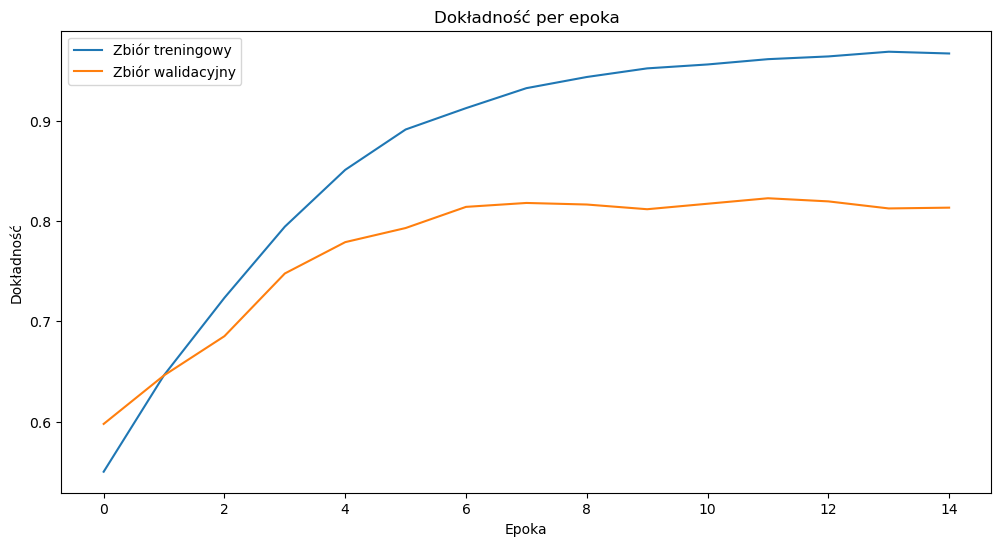

In [14]:
plt.figure(figsize=(12, 6))
plt.plot(best_history.history['accuracy'], label='Zbiór treningowy')
plt.plot(best_history.history['val_accuracy'], label='Zbiór walidacyjny')
plt.title('Dokładność per epoka')
plt.xlabel('Epoka')
plt.ylabel('Dokładność')
plt.legend()
plt.show()

# LSTM loss per epoch

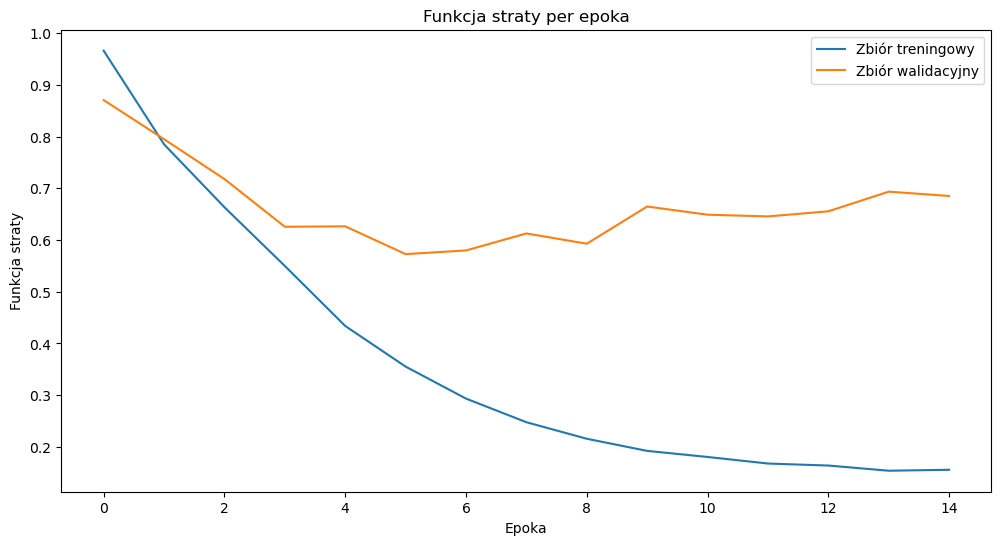

In [15]:
plt.figure(figsize=(12, 6))
plt.plot(best_history.history['loss'], label='Zbiór treningowy')
plt.plot(best_history.history['val_loss'], label='Zbiór walidacyjny')
plt.title('Funkcja straty per epoka')
plt.xlabel('Epoka')
plt.ylabel('Funkcja straty')
plt.legend()
plt.show()

# Confusion matrix

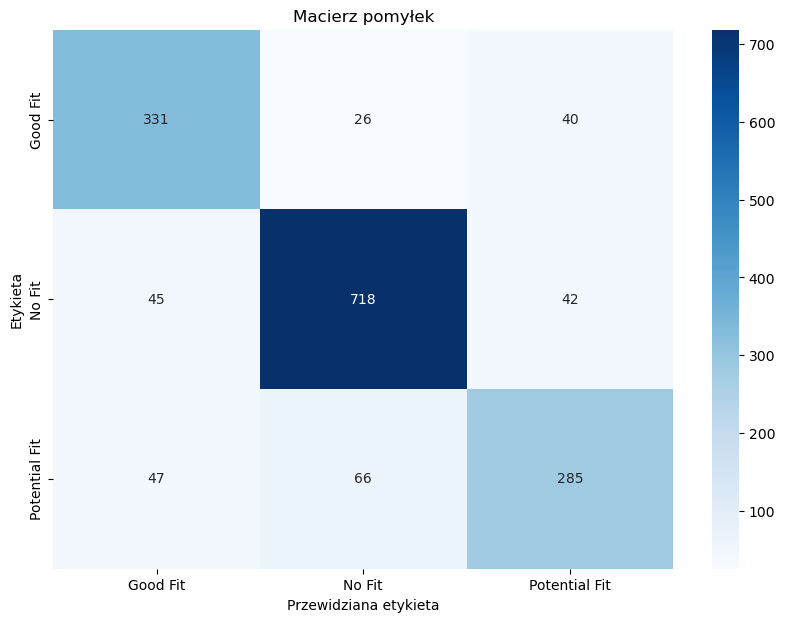

In [16]:
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Macierz pomyłek')
plt.xlabel('Przewidziana etykieta')
plt.ylabel('Etykieta')
plt.show()

# LSTM Gini and ROC

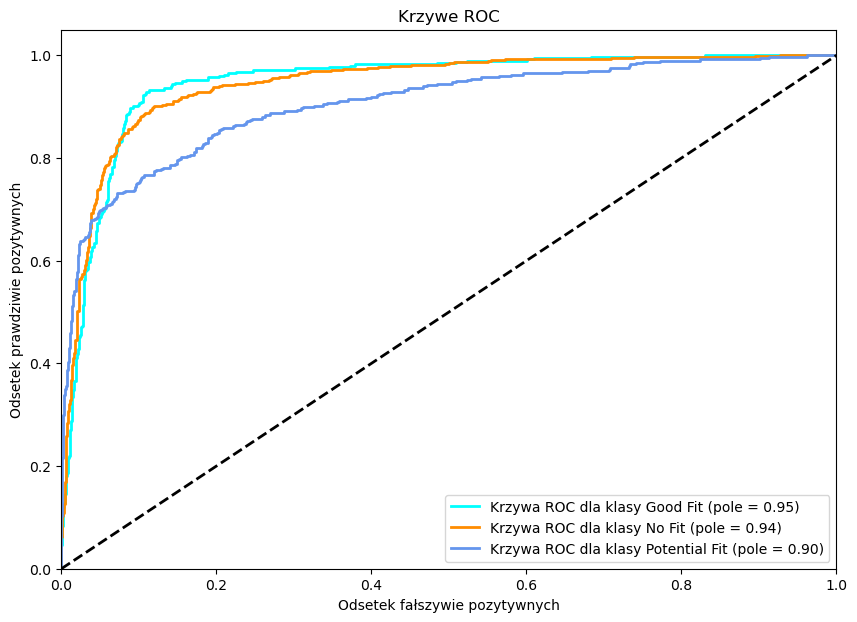

Gini: 0.8650622279681996


In [17]:
fpr = {}
tpr = {}
roc_auc = {}

for i in range(len(label_encoder.classes_)):
    fpr[i], tpr[i], _ = roc_curve(y_test, y_pred_probs[:, i], pos_label=i)
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 7))
colors = ['aqua', 'darkorange', 'cornflowerblue']
for i, color in zip(range(len(label_encoder.classes_)), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'Krzywa ROC dla klasy {label_encoder.classes_[i]} (pole = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Odsetek fałszywie pozytywnych')
plt.ylabel('Odsetek prawdziwie pozytywnych')
plt.title('Krzywe ROC')
plt.legend(loc="lower right")
plt.show()

roc_auc = roc_auc_score(y_test, y_pred_probs, multi_class='ovr')
gini = 2 * roc_auc - 1
print(f'Gini: {gini}')

# Plot model

Model: "functional_42"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_84      │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_85      │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_42        │ (None, 100, 128)  │  1,280,000 │ input_layer_84[0… │
│ (Embedding)         │                   │            │ input_layer_85[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_42 (LSTM)      │ (None, 100, 64)   │     49,408 │ embedding_42[0][… │
│                     │                   │            │ embedding_42[1][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_210 (Lambda) │ (None, 64)        │          0 │ lstm_42[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_211 (Lambda) │ (None, 64)        │          0 │ lstm_42[1][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_212 (Lambda) │ (None, 64)        │          0 │ lambda_210[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_213 (Lambda) │ (None, 64)        │          0 │ lambda_211[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_214 (Lambda) │ (None, 1)         │          0 │ lambda_212[0][0], │
│                     │                   │            │ lambda_213[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_42      │ (None, 129)       │          0 │ lambda_212[0][0], │
│ (Concatenate)       │                   │            │ lambda_213[0][0], │
│                     │                   │            │ lambda_214[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_84 (Dense)    │ (None, 64)        │      8,320 │ concatenate_42[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_42          │ (None, 64)        │          0 │ dense_84[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_85 (Dense)    │ (None, 3)         │        195 │ dropout_42[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 4,013,771 (15.31 MB)

 Trainable params: 1,337,923 (5.10 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,675,848 (10.21 MB)

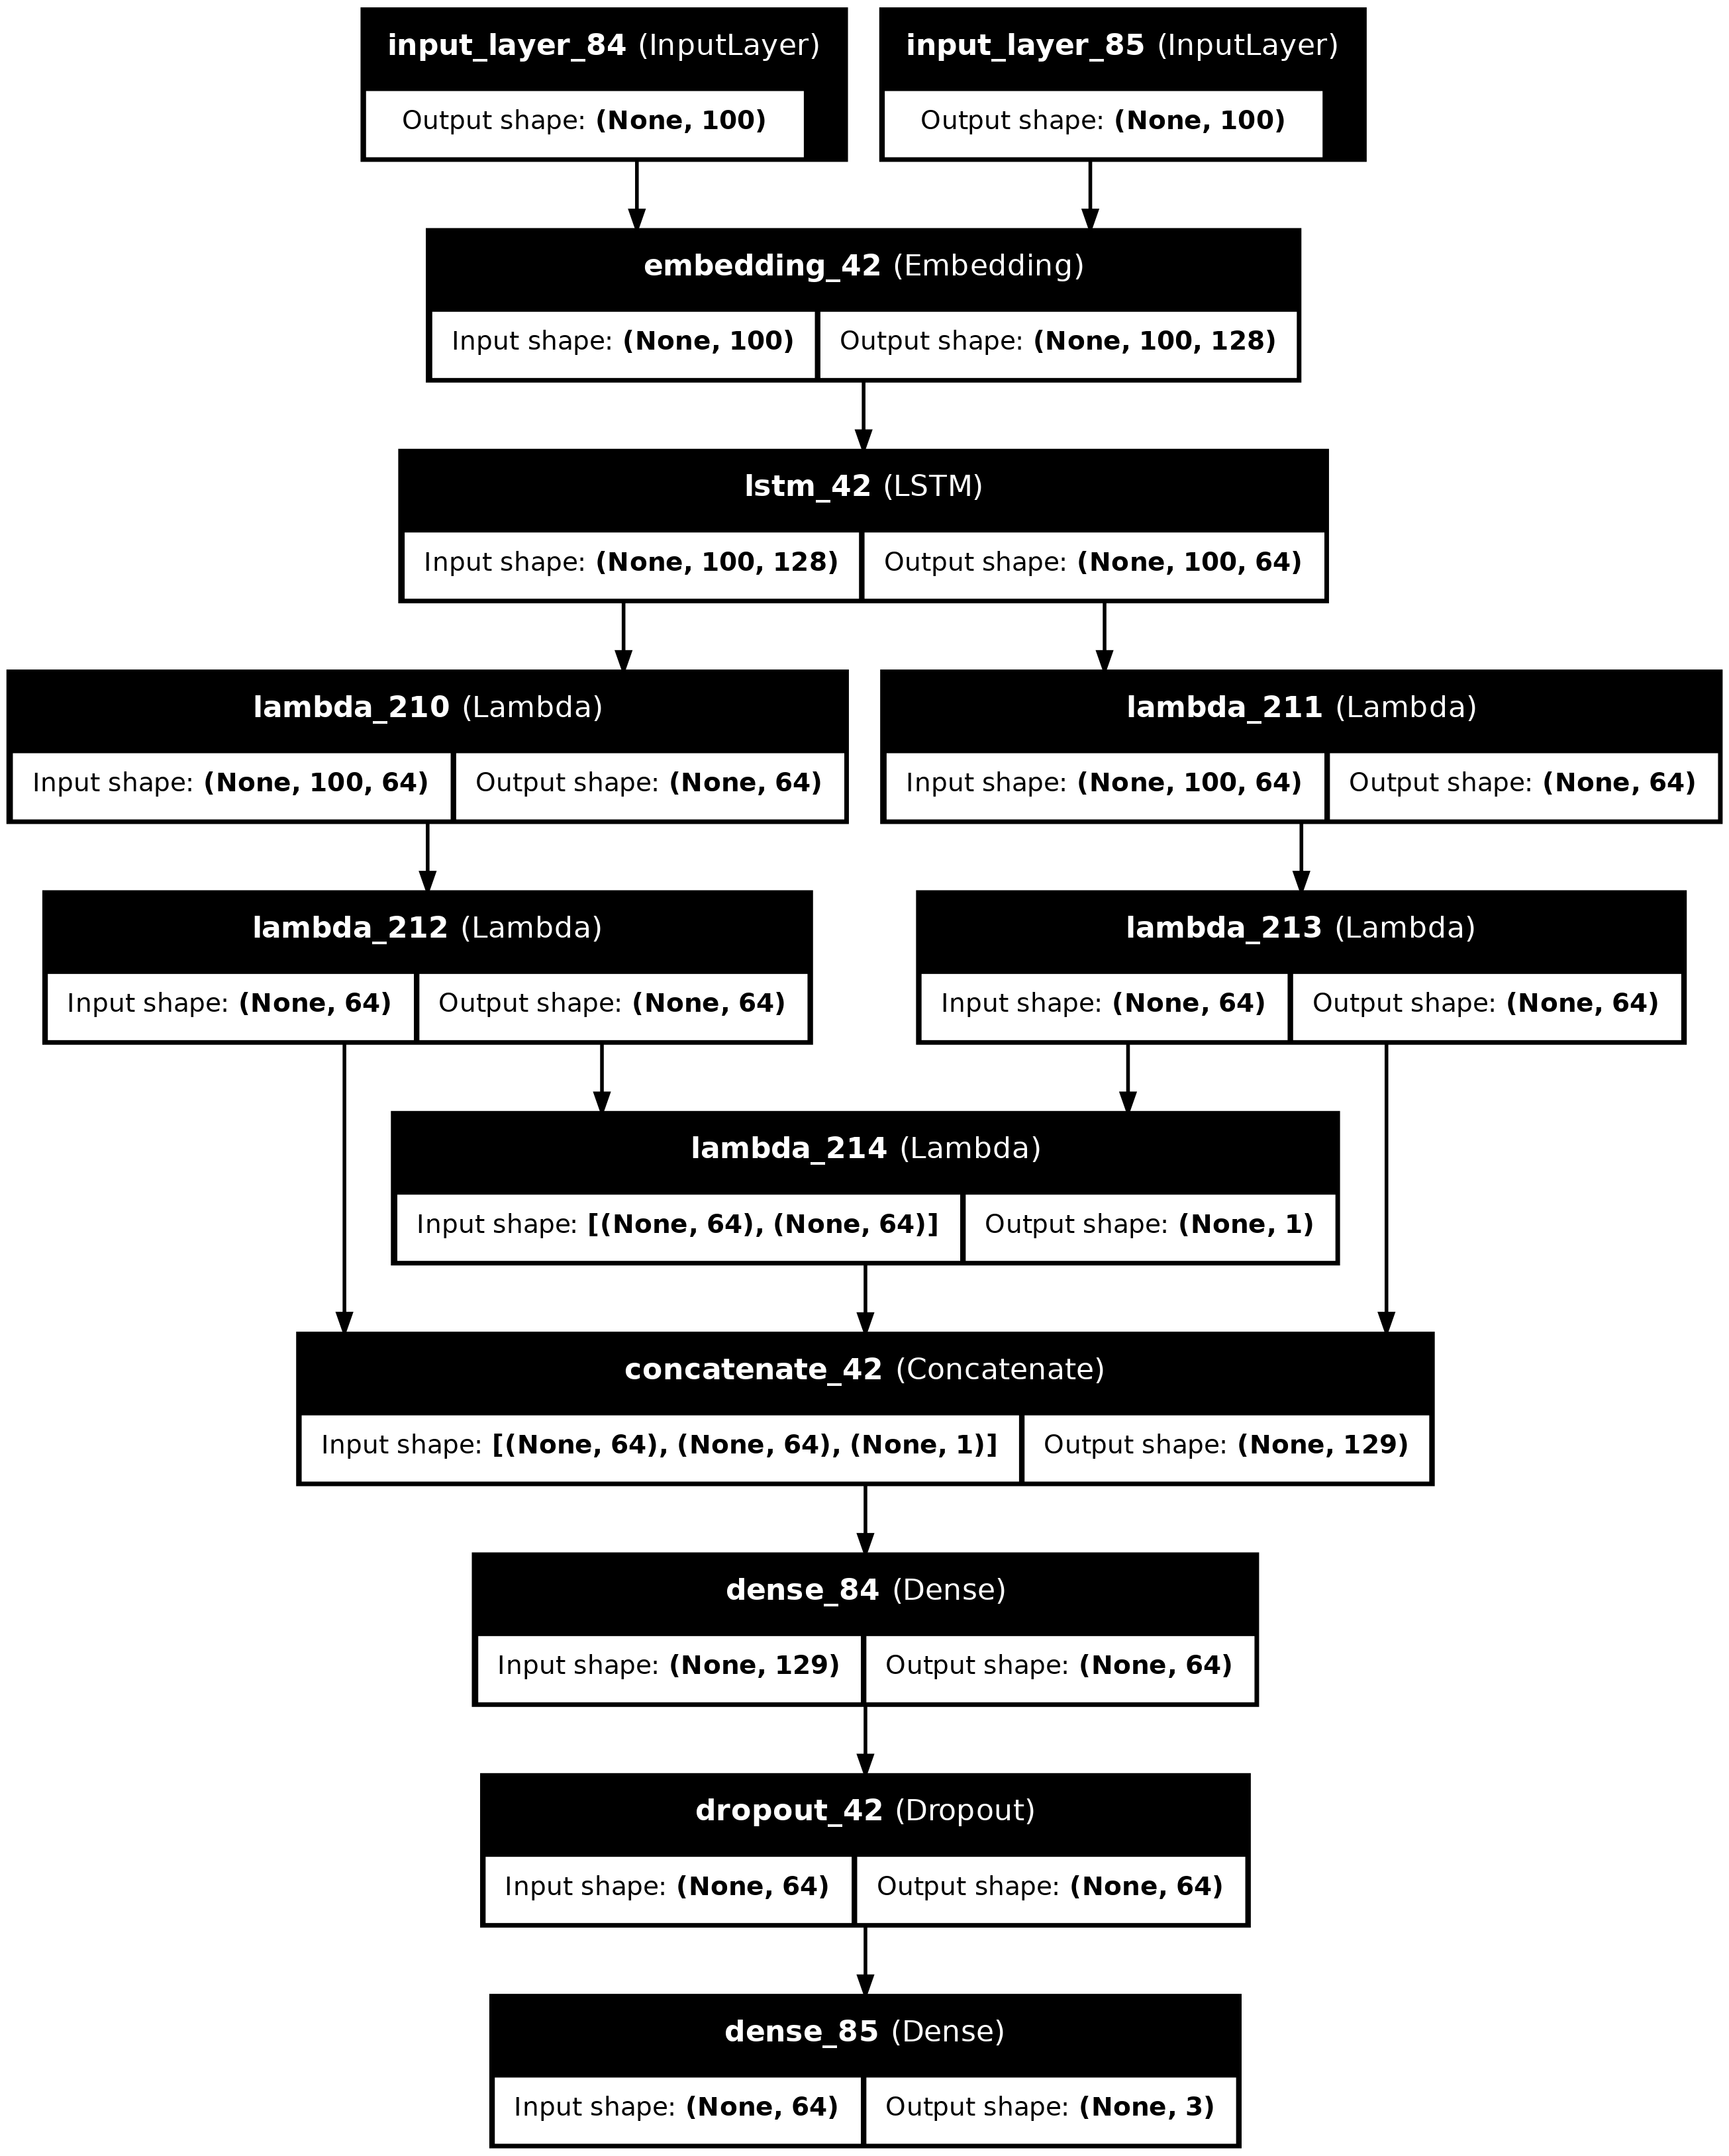

In [18]:
best_model.summary()

plot_model(best_model, to_file=MODEL_IMG_FILENAME, show_shapes=True, show_layer_names=True)

# Save model and vectorizer

In [19]:
best_model.save_weights(SERIALIZED_MODEL_FILENAME)

input_text = tf.keras.Input(shape=(1,), dtype=tf.string)
vectorized_text = vectorizer(input_text)
vectorizer_model = Model(inputs=input_text, outputs=vectorized_text)
vectorizer_model.save(SERIALIZED_VECTORIZER_FILENAME)